# Life Expectancy Data Science Project

---------------------------------------------

### Introduction
This analysis explores a life expectancy dataset, aiming to uncover factors affecting life expectancy across countries over time. We'll handle missing values, engineer features, perform exploratory analysis, visualize patterns, and build a regression model to predict life expectancy.

### Objectives
- Understand the structure and quality of the dataset
- Identify key features affecting life expectancy
- Handle missing data appropriately
- Engineer new features to improve prediction
- Visualize relationships and trends
- Build a regression model to predict life expectancy
- Evaluate model performance using cross-validation
- Derive actionable insights

### Task 1: Explore Dataset and Missing Values

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.stats.mstats import winsorize
import re
from scipy.stats import median_abs_deviation
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
df = pd.read_csv('Life_Expectancy_Data.csv')
df.shape 

(1649, 22)

In [3]:
df.dtypes

Country                             object
Year                                 int64
Status                              object
Life expectancy                    float64
Adult Mortality                      int64
infant deaths                        int64
Alcohol                            float64
percentage expenditure             float64
Hepatitis B                          int64
Measles                              int64
 BMI                               float64
under-five deaths                    int64
Polio                                int64
Total expenditure                  float64
Diphtheria                           int64
 HIV/AIDS                          float64
GDP                                float64
Population                         float64
 thinness  1-19 years              float64
 thinness 5-9 years                float64
Income composition of resources    float64
Schooling                          float64
dtype: object

In [4]:
df.dtypes.value_counts()

float64    12
int64       8
object      2
Name: count, dtype: int64

In [5]:
df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

In [6]:

for column in df.columns:
    # Remove leading/trailing spaces and compress multiple spaces into single spaces
    cleaned_column = re.sub(r'\s+', ' ', column.strip())
    df.rename(columns={column: cleaned_column}, inplace=True)


df.to_csv("Cleaned_Life_Expectancy.csv", index=False)
df.columns


Index(['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness 1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')

#### Statistical analysis

In [7]:
# Display all columns in the DataFrame
pd.set_option('display.max_columns', None)
#Description of the dataset transposed
df.describe(include='all')

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,1649,1649.000000,1649,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1.649000e+03,1649.000000,1649.000000,1649.000000,1649.000000
unique,133,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Afghanistan,NaN,Developing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,16,NaN,1407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2007.840509,NaN,69.302304,168.215282,32.553062,4.533196,698.973558,79.217708,2224.494239,38.128623,44.220133,83.564585,5.955925,84.155246,1.983869,5566.031887,1.465363e+07,4.850637,4.907762,0.631551,12.119891
std,NaN,4.087711,NaN,8.796834,125.310417,120.847190,4.029189,1759.229336,25.604664,10085.802019,19.754249,162.897999,22.450557,2.299385,21.579193,6.032360,11475.900117,7.046039e+07,4.599228,4.653757,0.183089,2.795388
min,NaN,2000.000000,NaN,44.000000,1.000000,0.000000,0.010000,0.000000,2.000000,0.000000,2.000000,0.000000,3.000000,0.740000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,4.200000
25%,NaN,2005.000000,NaN,64.400000,77.000000,1.000000,0.810000,37.438577,74.000000,0.000000,19.500000,1.000000,81.000000,4.410000,82.000000,0.100000,462.149650,1.918970e+05,1.600000,1.700000,0.509000,10.300000
50%,NaN,2008.000000,NaN,71.700000,148.000000,3.000000,3.790000,145.102253,89.000000,15.000000,43.700000,4.000000,93.000000,5.840000,92.000000,0.100000,1592.572182,1.419631e+06,3.000000,3.200000,0.673000,12.300000
75%,NaN,2011.000000,NaN,75.000000,227.000000,22.000000,7.340000,509.389994,96.000000,373.000000,55.800000,29.000000,97.000000,7.470000,97.000000,0.700000,4718.512910,7.658972e+06,7.100000,7.100000,0.751000,14.000000


In [8]:
df.head(20)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263,62,0.01,71.279624,65,1154,19.1,83,6,8.16,65,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271,64,0.01,73.523582,62,492,18.6,86,58,8.18,62,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268,66,0.01,73.219243,64,430,18.1,89,62,8.13,64,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272,69,0.01,78.184215,67,2787,17.6,93,67,8.52,67,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275,71,0.01,7.097109,68,3013,17.2,97,68,7.87,68,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
5,Afghanistan,2010,Developing,58.8,279,74,0.01,79.679367,66,1989,16.7,102,66,9.20,66,0.1,553.328940,2883167.0,18.4,18.4,0.448,9.2
6,Afghanistan,2009,Developing,58.6,281,77,0.01,56.762217,63,2861,16.2,106,63,9.42,63,0.1,445.893298,284331.0,18.6,18.7,0.434,8.9
7,Afghanistan,2008,Developing,58.1,287,80,0.03,25.873925,64,1599,15.7,110,64,8.33,64,0.1,373.361116,2729431.0,18.8,18.9,0.433,8.7
8,Afghanistan,2007,Developing,57.5,295,82,0.02,10.910156,63,1141,15.2,113,63,6.73,63,0.1,369.835796,26616792.0,19.0,19.1,0.415,8.4
9,Afghanistan,2006,Developing,57.3,295,84,0.03,17.171518,64,1990,14.7,116,58,7.43,58,0.1,272.563770,2589345.0,19.2,19.3,0.405,8.1


In [9]:
print(df.duplicated())

0       False
1       False
2       False
3       False
4       False
        ...  
1644    False
1645    False
1646    False
1647    False
1648    False
Length: 1649, dtype: bool


In [10]:
#Find total of duplicated values
print(df.duplicated().sum())

0


In [11]:
# Get the number of unique countries from the 'Country' column
number_of_countries = df['Country'].nunique()

# Print the number of unique countries
print(f"The total number of unique countries in the dataset is: {number_of_countries}")

The total number of unique countries in the dataset is: 133


### Task 2: Handle Missing Data and Justify Method

In [12]:
null_values = df.isnull().sum()

In [13]:
#Checks if any column has NaN
df.isnull().any()

Country                            False
Year                               False
Status                             False
Life expectancy                    False
Adult Mortality                    False
infant deaths                      False
Alcohol                            False
percentage expenditure             False
Hepatitis B                        False
Measles                            False
BMI                                False
under-five deaths                  False
Polio                              False
Total expenditure                  False
Diphtheria                         False
HIV/AIDS                           False
GDP                                False
Population                         False
thinness 1-19 years                False
thinness 5-9 years                 False
Income composition of resources    False
Schooling                          False
dtype: bool

In [14]:
#Checks if any row has NaN
df.isnull().any(axis=1)

0       False
1       False
2       False
3       False
4       False
        ...  
1644    False
1645    False
1646    False
1647    False
1648    False
Length: 1649, dtype: bool

In [15]:
#Checks if all values in a column are NaN
df.isnull().all()

Country                            False
Year                               False
Status                             False
Life expectancy                    False
Adult Mortality                    False
infant deaths                      False
Alcohol                            False
percentage expenditure             False
Hepatitis B                        False
Measles                            False
BMI                                False
under-five deaths                  False
Polio                              False
Total expenditure                  False
Diphtheria                         False
HIV/AIDS                           False
GDP                                False
Population                         False
thinness 1-19 years                False
thinness 5-9 years                 False
Income composition of resources    False
Schooling                          False
dtype: bool

In [16]:
#Checks if all values in a row are NaN
df.isnull().all(axis=1)

0       False
1       False
2       False
3       False
4       False
        ...  
1644    False
1645    False
1646    False
1647    False
1648    False
Length: 1649, dtype: bool

In [17]:
null_percentage = (df.isnull().sum() / len(df))*100
print(null_percentage)

Country                            0.0
Year                               0.0
Status                             0.0
Life expectancy                    0.0
Adult Mortality                    0.0
infant deaths                      0.0
Alcohol                            0.0
percentage expenditure             0.0
Hepatitis B                        0.0
Measles                            0.0
BMI                                0.0
under-five deaths                  0.0
Polio                              0.0
Total expenditure                  0.0
Diphtheria                         0.0
HIV/AIDS                           0.0
GDP                                0.0
Population                         0.0
thinness 1-19 years                0.0
thinness 5-9 years                 0.0
Income composition of resources    0.0
Schooling                          0.0
dtype: float64


In [18]:
missing_df = pd.DataFrame({'Missing Values': null_values, 'Percent Missing': null_percentage})
missing_df[missing_df['Missing Values'] > 0]

,Missing Values,Percent Missing


### Advanced mechanisms to handle missing data

#### Outlier detection
1. Z-Score

In [19]:

# === Initialize tracker ===
outlier_indices_per_column = {col: set() for col in df.select_dtypes(include='number').columns}

# === Z-Score function ===
def detect_outliers(series, threshold=3.5):
    median = series.median()
    mad = median_abs_deviation(series, scale='normal')  # scaled to be comparable to std
    if mad == 0:
        return pd.Series([False] * len(series), index=series.index)
    z_scores = 0.6745 * (series - median) / mad
    return abs(z_scores) > threshold

# === Process per country ===
for country, group in df.groupby('Country'):
    for col in df.select_dtypes(include='number').columns:
        is_outlier = detect_outliers(group[col])
        outlier_indices_per_column[col].update(group[is_outlier].index)

# === Build summary table ===
summary = []
for col, indices in outlier_indices_per_column.items():
    count = len(indices)
    summary.append({
        'Column': col,
        'Outlier Count': count,
        'Percentage': round((count / len(df)) * 100, 2)
    })

# === Create DataFrame and show results ===
outlier_summary = pd.DataFrame(summary).sort_values(by='Outlier Count', ascending=False)

print("Outlier Detection Summary (Z-Score per Country, Unique Rows Only)")
print("=" * 70)
print(outlier_summary.to_string(index=False))


Outlier Detection Summary (Z-Score per Country, Unique Rows Only)
                         Column  Outlier Count  Percentage
                     Population            390       23.65
                        Measles            180       10.92
                Adult Mortality            174       10.55
                            BMI            151        9.16
                    Hepatitis B            134        8.13
                     Diphtheria            113        6.85
                          Polio            106        6.43
                        Alcohol             92        5.58
              Total expenditure             43        2.61
         percentage expenditure             43        2.61
                            GDP             35        2.12
Income composition of resources             32        1.94
                Life expectancy             25        1.52
            thinness 1-19 years             24        1.46
             thinness 5-9 years             23   

2. Box plot

C:\Users\HP\AppData\Local\Temp\ipykernel_5280\4264789427.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tagged = melted.groupby(['Country', 'Feature'], group_keys=False).apply(detect_and_tag_outliers)
C:\Users\HP\AppData\Local\Temp\ipykernel_5280\4264789427.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tagged = melted.groupby(['Country', 'Feature'], group_keys=False).apply(detect_and_tag_outliers)
C:\Use

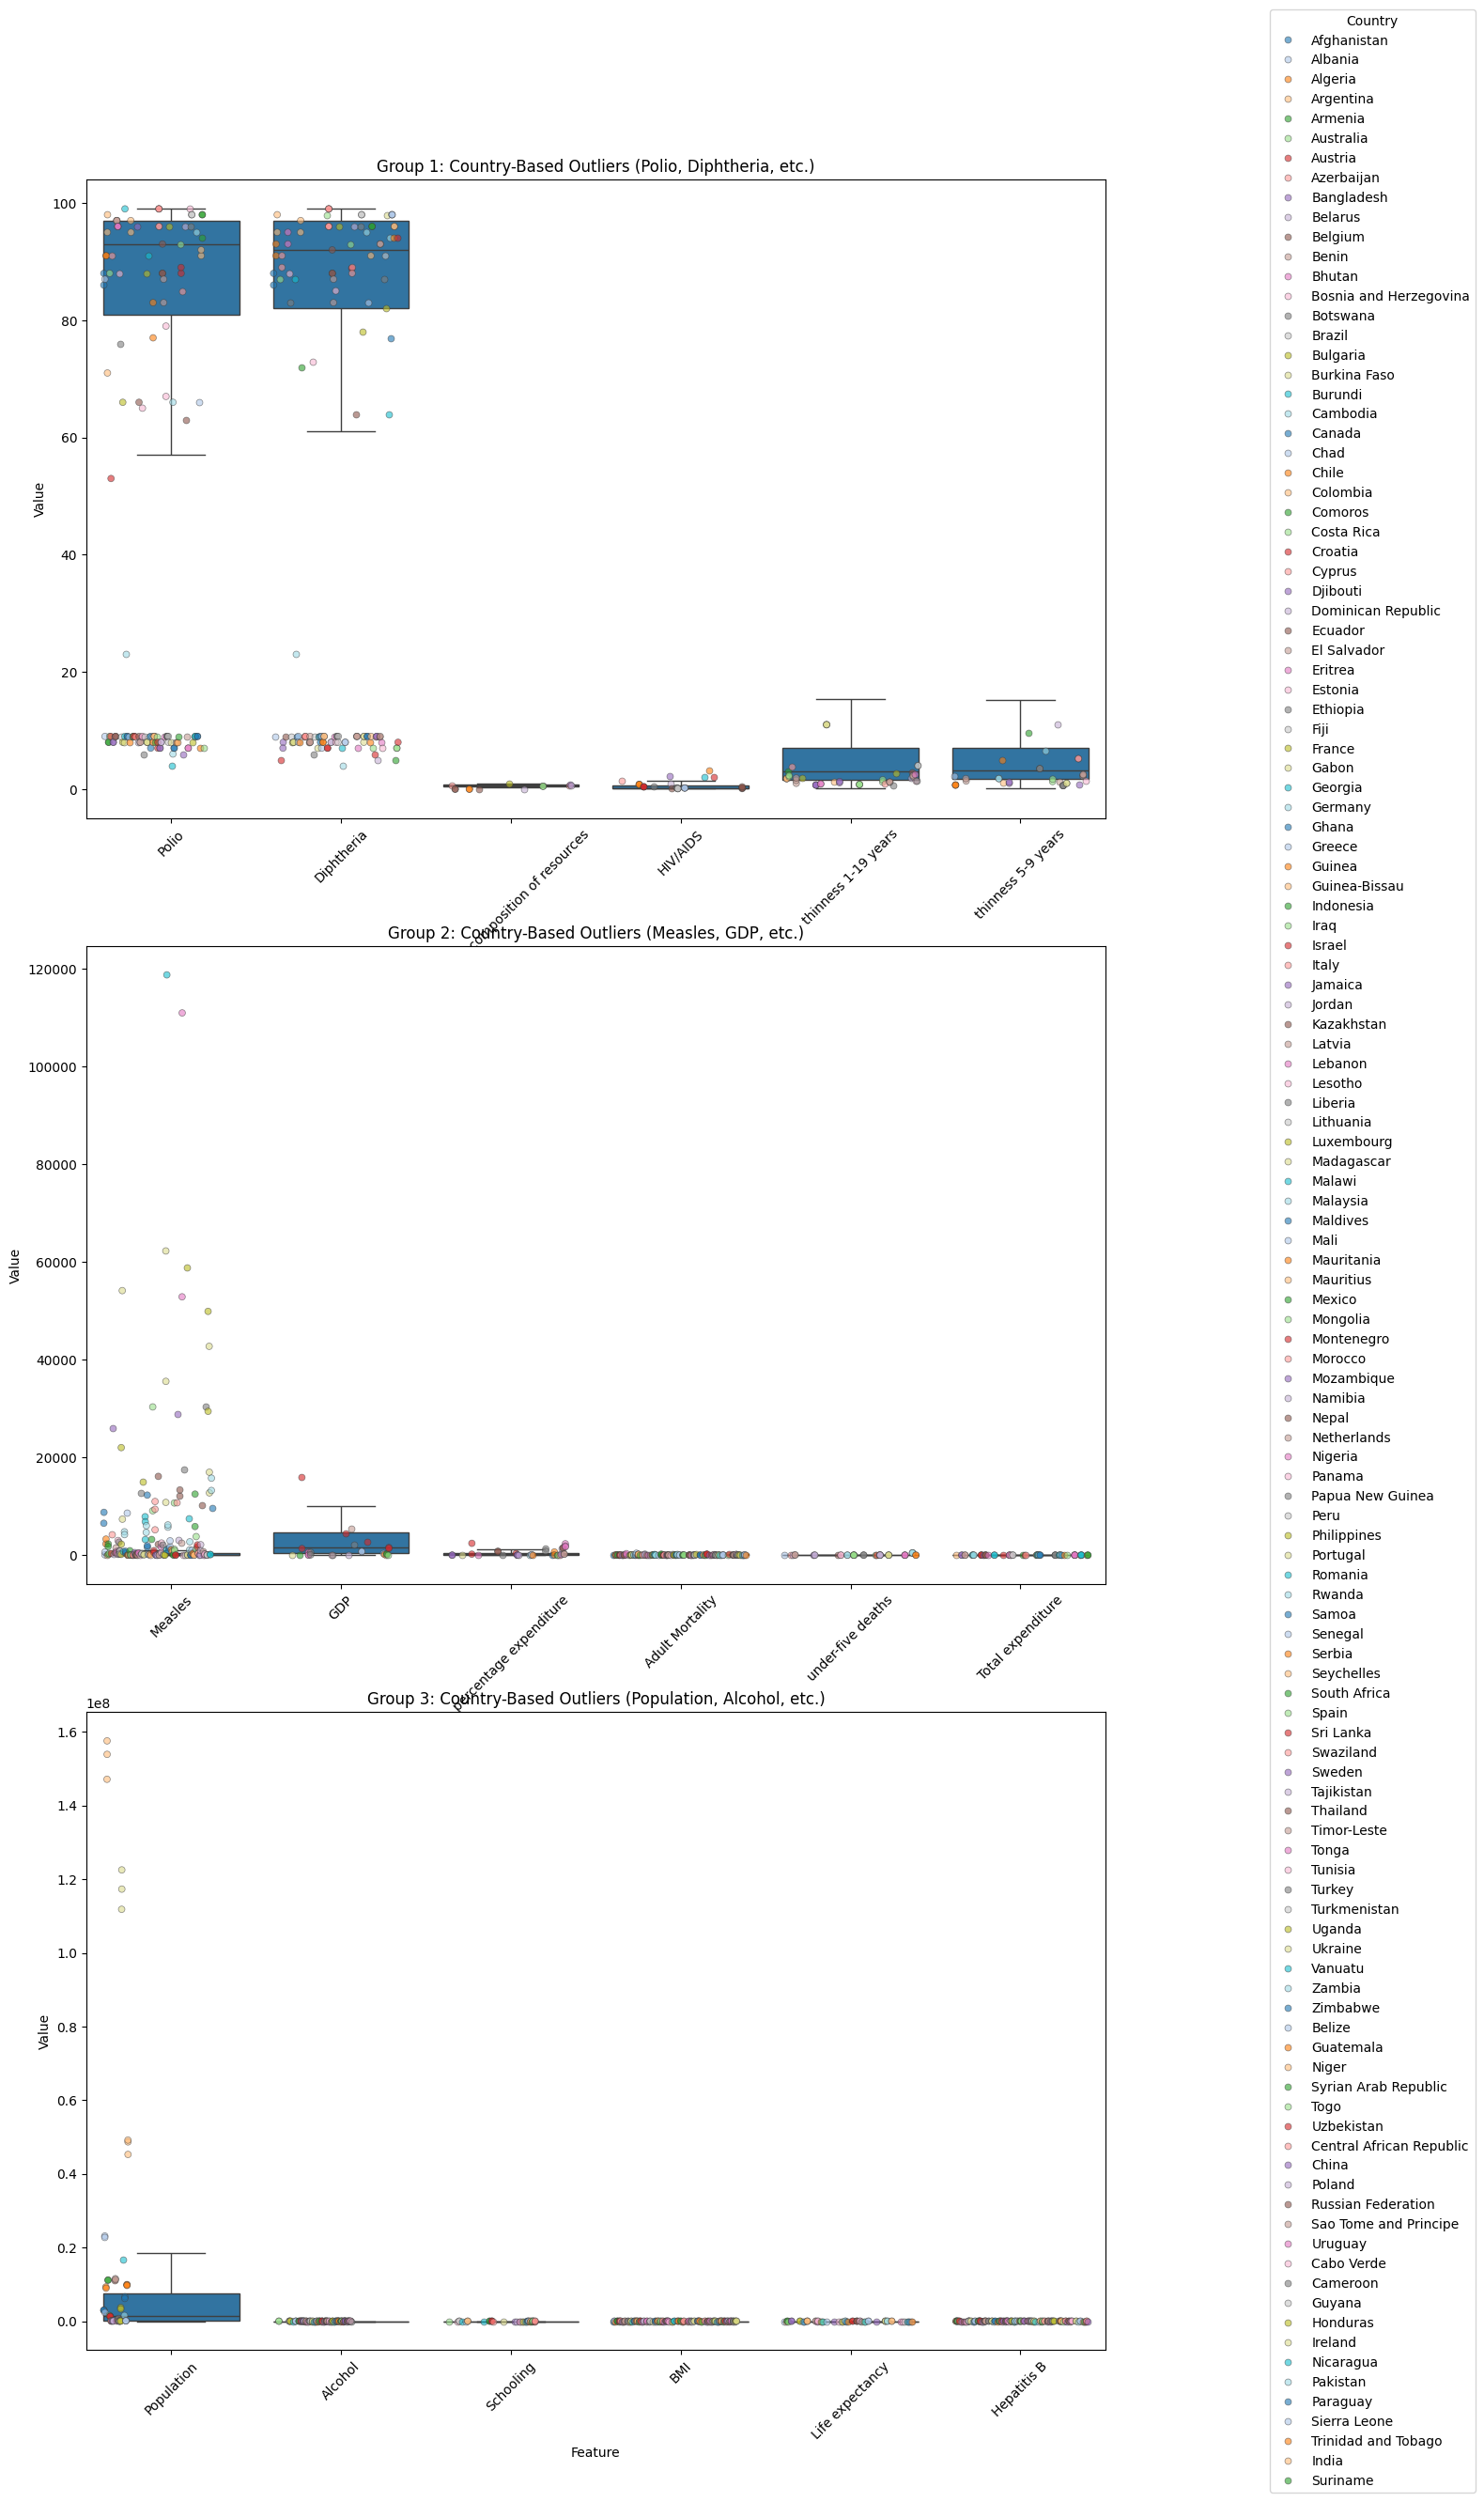

In [20]:
# === First feature group ===
features_1 = ['Polio', 'Diphtheria', 'Income composition of resources',
              'HIV/AIDS', 'thinness 1-19 years', 'thinness 5-9 years']

# === Second feature group ===
features_2 = ['Measles', 'GDP', 'percentage expenditure', 'Adult Mortality', 'under-five deaths', 'Total expenditure']

features_3 = ['Population', 'Alcohol', 'Schooling', 'BMI', 'Life expectancy', 'Hepatitis B']

# === Prepare melted data for both groups ===
def melt_and_tag_outliers(df, features):
    melted = df[['Country'] + features].melt(id_vars='Country', var_name='Feature', value_name='Value')

    def detect_and_tag_outliers(group):
        q1 = group['Value'].quantile(0.25)
        q3 = group['Value'].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        group['Outlier'] = (group['Value'] < lower) | (group['Value'] > upper)
        return group

    tagged = melted.groupby(['Country', 'Feature'], group_keys=False).apply(detect_and_tag_outliers)
    return tagged

df_tagged_1 = melt_and_tag_outliers(df, features_1)
df_tagged_2 = melt_and_tag_outliers(df, features_2)
df_tagged_3 = melt_and_tag_outliers(df, features_3)

# === Create subplots ===
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(14, 30))  # reduce figure height


# --- Plot 1 ---
sns.boxplot(data=df_tagged_1, x='Feature', y='Value', showfliers=False, ax=ax1)
sns.stripplot(
    data=df_tagged_1[df_tagged_1['Outlier']],
    x='Feature',
    y='Value',
    hue='Country',
    dodge=True,
    jitter=True,
    marker='o',
    alpha=0.6,
    linewidth=0.5,
    edgecolor='gray',
    palette='tab20',
    ax=ax1
)
ax1.set_title("Group 1: Country-Based Outliers (Polio, Diphtheria, etc.)")
ax1.tick_params(axis='x', rotation=45)
ax1.legend_.remove()


# --- Plot 2 ---
sns.boxplot(data=df_tagged_2, x='Feature', y='Value', showfliers=False, ax=ax2)
sns.stripplot(
    data=df_tagged_2[df_tagged_2['Outlier']],
    x='Feature',
    y='Value',
    hue='Country',
    dodge=True,
    jitter=True,
    marker='o',
    alpha=0.6,
    linewidth=0.5,
    edgecolor='gray',
    palette='tab20',
    ax=ax2
)
ax2.set_title("Group 2: Country-Based Outliers (Measles, GDP, etc.)")
ax2.tick_params(axis='x', rotation=45)

ax2.legend_.remove()

# --- Plot 3 ---
sns.boxplot(data=df_tagged_3, x='Feature', y='Value', showfliers=False, ax=ax3)
sns.stripplot(
    data=df_tagged_3[df_tagged_3['Outlier']],
    x='Feature',
    y='Value',
    hue='Country',
    dodge=True,
    jitter=True,
    marker='o',
    alpha=0.6,
    linewidth=0.5,
    edgecolor='gray',
    palette='tab20',
    ax=ax3
)
ax3.set_title("Group 3: Country-Based Outliers (Population, Alcohol, etc.)")
ax3.tick_params(axis='x', rotation=45)
ax3.legend_.remove()


# === Add legend outside the full figure ===
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, title='Country', bbox_to_anchor=(1.02, 0.5), loc='center left')
plt.show()


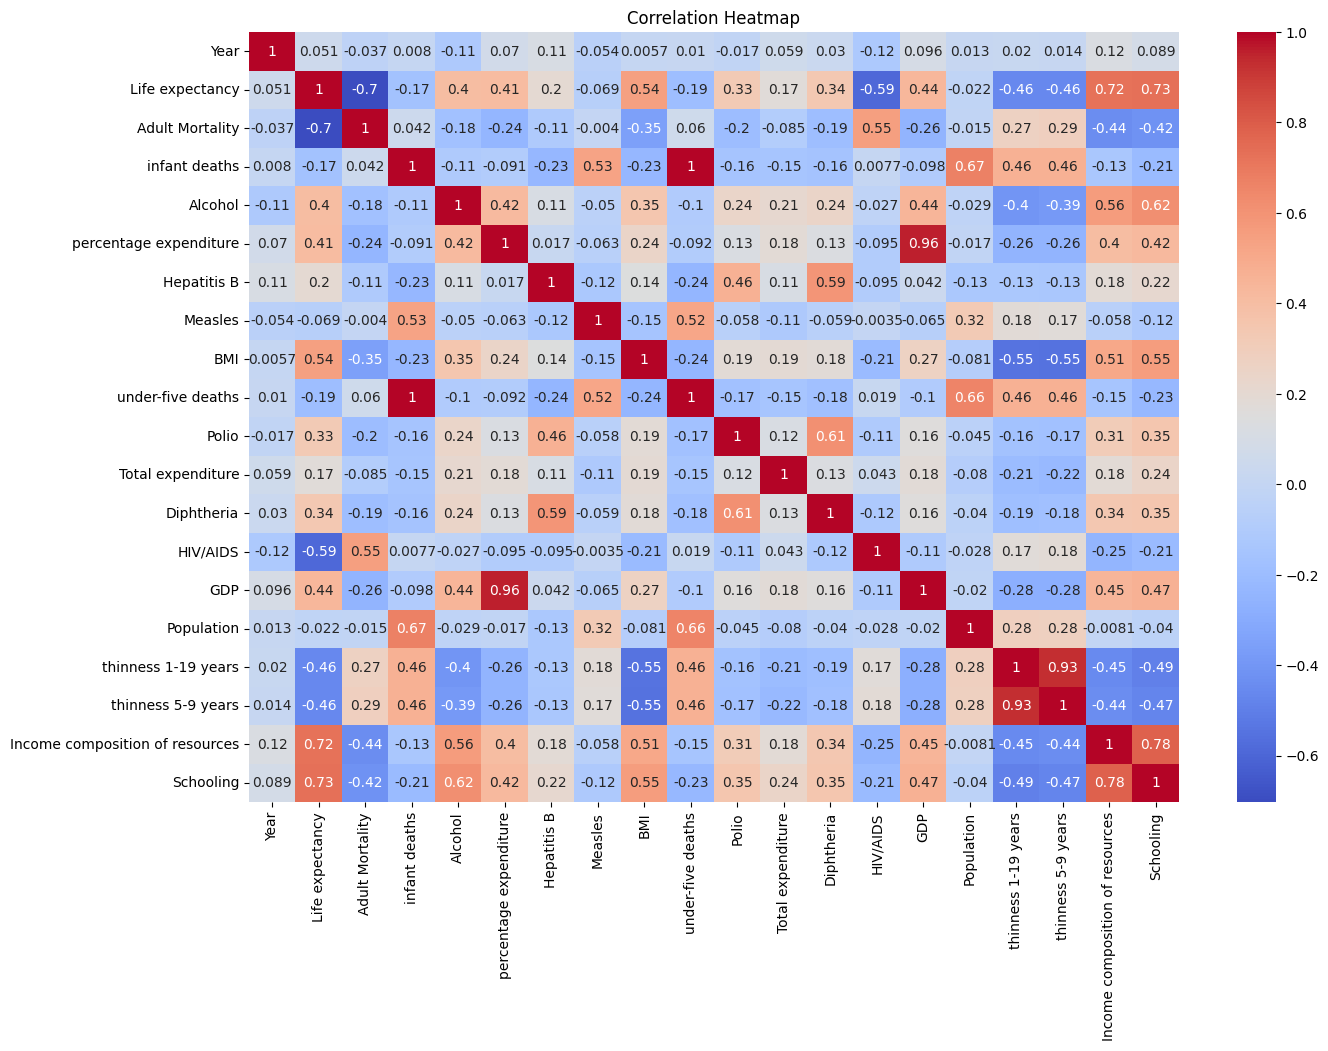

In [21]:
plt.figure(figsize=(15,10))
sns.heatmap(df.select_dtypes(include='number').corr(), cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap')
plt.show()

### Task 3: Apply Chosen Method and Evaluate

### Implementation of the chosen methods

In [22]:
# These will use percentile-based capping due to skewness
skewed_features = ['Adult Mortality']
# These will use IQR capping
iqr_features = ['Polio', 'Diphtheria', 'Hepatitis B',
                'Total expenditure']
# These will use log transformation
log_transform_features = ['Measles', 'Population', 'Alcohol', 'percentage expenditure']

# Features to process (but we'll keep all other features unchanged)
features_to_process = skewed_features + iqr_features + log_transform_features 

# === Impute missing values using country-wise median for ALL features ===
print("🔧 Imputing missing values with country-wise median...")
# Get all numeric columns except Country and Year
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove Country and Year if they exist in numeric columns
numeric_cols = [col for col in numeric_cols if col not in ['Country', 'Year']]

for col in numeric_cols:
    if col in df.columns and df[col].isnull().any():
        df[col] = df.groupby('Country')[col].transform(lambda x: x.fillna(x.median()))
        if df[col].isnull().any():
            df[col].fillna(df[col].median(), inplace=True)
print("Imputation complete.")

# === Helper Functions ===

def percentile_cap_grouped(df, col, lower=0.01, upper=0.99):
    """Apply percentile capping per country."""
    def cap(x):
        return x.clip(lower=x.quantile(lower), upper=x.quantile(upper))
    return df.groupby("Country")[col].transform(cap)

def iqr_cap_grouped(df, col):
    """Apply IQR capping per country."""
    def cap(x):
        q1 = x.quantile(0.25)
        q3 = x.quantile(0.75)
        iqr = q3 - q1
        if iqr == 0 or x.isnull().all():
            return x
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        return x.clip(lower, upper)
    return df.groupby("Country")[col].transform(cap)

def apply_log_transform_safely(x):
    """Log transform safely, avoiding log(0)."""
    return np.log1p(x.clip(lower=0))

# === Apply transformations ONLY to specified features ===
print("\nApplying transformations and tracking changes...")
df_cleaned = df.copy()
changes_summary = {}



# 2. IQR Capping → other features
for col in iqr_features:
    if col in df_cleaned.columns:
        before = df_cleaned[col].copy()
        df_cleaned[col] = iqr_cap_grouped(df_cleaned, col)
        changes_summary[col] = (df_cleaned[col] != before).sum()
        print(f"✔ IQR Capped → {col}: {changes_summary[col]} values modified")

# 3. Log Transform → log_transform_features
for col in log_transform_features:
    if col in df_cleaned.columns:
        before = df_cleaned[col].copy()
        df_cleaned[col] = apply_log_transform_safely(df_cleaned[col])
        changes_summary[col] = (df_cleaned[col] != before).sum()
        print(f"✔ Log Transformed → {col}: {changes_summary[col]} values modified")

# === Save cleaned dataset with ALL original features ===
# Keep all columns from the original dataset
df_final = df_cleaned.copy()
df_final.to_csv("Cleaned_Life_Expectancy.csv", index=False)

# === Summary ===
print("Final Summary of Outlier Handling:")
for col, count in changes_summary.items():
    if col in iqr_features:
        method = "IQR Capped"
    else:
        method = "Log Transformed"
    print(f"✔ {method} → {col}: {count} values modified")

print(f"Dataset Info:")
print(f"Total columns in cleaned dataset: {len(df_final.columns)}")
print(f"Columns processed: {len(features_to_process)}")
print(f"Columns unchanged: {len(df_final.columns) - len(features_to_process)}")

print("Cleaned dataset saved as: Cleaned_Life_Expectancy.csv")


🔧 Imputing missing values with country-wise median...
Imputation complete.

Applying transformations and tracking changes...
✔ IQR Capped → Polio: 130 values modified
✔ IQR Capped → Diphtheria: 122 values modified
✔ IQR Capped → Hepatitis B: 156 values modified
✔ IQR Capped → Total expenditure: 60 values modified
✔ Log Transformed → Measles: 1095 values modified
✔ Log Transformed → Population: 1649 values modified
✔ Log Transformed → Alcohol: 1649 values modified
✔ Log Transformed → percentage expenditure: 1644 values modified
Final Summary of Outlier Handling:
✔ IQR Capped → Polio: 130 values modified
✔ IQR Capped → Diphtheria: 122 values modified
✔ IQR Capped → Hepatitis B: 156 values modified
✔ IQR Capped → Total expenditure: 60 values modified
✔ Log Transformed → Measles: 1095 values modified
✔ Log Transformed → Population: 1649 values modified
✔ Log Transformed → Alcohol: 1649 values modified
✔ Log Transformed → percentage expenditure: 1644 values modified
Dataset Info:
Total colu

In [23]:
# Handling missing values for BMI separately
df = pd.read_csv('Cleaned_Life_Expectancy.csv')
# === Step 1: Identify and mask biologically implausible BMI values ===
# Values outside a reasonable range for a national average are considered invalid.
invalid_bmi_mask = (df['BMI'] < 15) | (df['BMI'] > 40)
num_bmi_replaced = invalid_bmi_mask.sum()

print(f"🔧 Identified {num_bmi_replaced} invalid BMI values to be imputed.")

# Replace these invalid values with NaN so they can be imputed
df['BMI'] = df['BMI'].mask(invalid_bmi_mask, np.nan)


# === Step 2: Impute missing BMI values using MICE ===
# MICE will predict missing BMI values based ONLY on Life expectancy, as requested.
impute_cols = ['Life expectancy', 'BMI']

imputer = IterativeImputer(max_iter=10, random_state=42)

# The imputer will predict the missing 'BMI' values based on 'Life expectancy'.
# The result is assigned back to the correct columns in the main DataFrame.
df[impute_cols] = imputer.fit_transform(df[impute_cols])
print("BMI values imputed successfully using MICE.")


# === Step 3: Save the ENTIRE cleaned dataset ===
# This saves the full DataFrame with all original columns, plus the cleaned BMI column.
df.to_csv('Cleaned_Life_Expectancy.csv', index=False)
print("Full dataset with cleaned BMI saved to 'Cleaned_Life_Expectancy.csv'")


# --- Output Summary ---
print("\nFinal Cleaned Dataset (Sample):")
# Displaying more columns to confirm they were all kept
print(df.head(10))

🔧 Identified 1092 invalid BMI values to be imputed.
BMI values imputed successfully using MICE.
Full dataset with cleaned BMI saved to 'Cleaned_Life_Expectancy.csv'

Final Cleaned Dataset (Sample):
       Country  Year      Status  Life expectancy  Adult Mortality  \
0  Afghanistan  2015  Developing             65.0              263   
1  Afghanistan  2014  Developing             59.9              271   
2  Afghanistan  2013  Developing             59.9              268   
3  Afghanistan  2012  Developing             59.5              272   
4  Afghanistan  2011  Developing             59.2              275   
5  Afghanistan  2010  Developing             58.8              279   
6  Afghanistan  2009  Developing             58.6              281   
7  Afghanistan  2008  Developing             58.1              287   
8  Afghanistan  2007  Developing             57.5              295   
9  Afghanistan  2006  Developing             57.3              295   

   infant deaths   Alcohol  per

In [24]:
# Handling missing values for GDP separately
df = pd.read_csv('Cleaned_Life_Expectancy.csv')
# --- Step 0: Initial State ---
print("\n--- Initial State of GDP Column ---")
initial_missing_gdp = df['GDP'].isnull().sum()
print(f"Number of missing GDP values initially: {initial_missing_gdp}")

# --- Step 1: Detect Outliers on a Per-Country Basis ---
print("\n--- Step 1: Detecting Outliers for Each Country Individually ---")

def get_country_upper_bound(series):
    """Calculates the upper outlier bound for a pandas Series."""
    q3 = series.quantile(0.75)
    iqr = q3 - series.quantile(0.25)
    return q3 + 1.5 * iqr

def get_country_lower_bound(series):
    """Calculates the lower outlier bound, enforcing a domain-specific minimum."""
    q1 = series.quantile(0.25)
    iqr = series.quantile(0.75) - q1
    iqr_lower_bound = q1 - 1.5 * iqr
    # Set an absolute minimum plausible value for GDP per capita
    domain_lower_bound = 100.0
    # Use the larger of the two lower bounds to be less restrictive, but never go below our absolute minimum.
    return max(iqr_lower_bound, domain_lower_bound)

# Apply outlier bound calculations for each country
country_upper_bounds = df.groupby('Country')['GDP'].transform(get_country_upper_bound)
country_lower_bounds = df.groupby('Country')['GDP'].transform(get_country_lower_bound)

# Create a boolean mask to identify rows with outlier GDP values
outlier_mask = (df['GDP'] < country_lower_bounds) | (df['GDP'] > country_upper_bounds)
outliers = df[outlier_mask]

print(f"Number of GDP outliers detected across all countries: {len(outliers)}")
if not outliers.empty:
    print("Sample of detected outliers:")
    print(outliers[['Country', 'Year', 'GDP']].head())

# --- Step 2: Mark Outliers as NaN ---
print("\n--- Step 2: Marking Outliers as Invalid (NaN) ---")
df.loc[outlier_mask, 'GDP'] = np.nan
total_missing_after_marking = df['GDP'].isnull().sum()
print(f"Total GDP values now missing (NaN): {total_missing_after_marking}")

# --- Step 3: Impute with Country-Specific Mean ---
print("\n--- Step 3: Imputing Missing/Invalid Values ---")
# Calculate the mean of valid GDPs for each country
country_gdp_mean = df.groupby('Country')['GDP'].transform('mean')
# Fill NaN values with the respective country's mean
df['GDP'].fillna(country_gdp_mean, inplace=True)

# Fallback to global mean if any country had all its values as NaN
global_gdp_mean = df['GDP'].mean()
df['GDP'].fillna(global_gdp_mean, inplace=True)
print("GDP values imputed successfully.")

# --- Step 4: Save the ENTIRE cleaned dataset ---
# This saves the full DataFrame with all original columns, plus the cleaned GDP column.
df.to_csv("Cleaned_Life_Expectancy.csv", index=False)
print("Full dataset with cleaned GDP saved to 'Cleaned_Life_Expectancy.csv'")

# --- Output Summary ---
print("\nFinal Cleaned Dataset (Sample):")
# Displaying the head of the full dataframe to confirm all columns were kept
print(df.head(10))


--- Initial State of GDP Column ---
Number of missing GDP values initially: 0

--- Step 1: Detecting Outliers for Each Country Individually ---
Number of GDP outliers detected across all countries: 133
Sample of detected outliers:
        Country  Year        GDP
4   Afghanistan  2011  63.537231
10  Afghanistan  2005  25.294130
25      Albania  2006  35.129300
41      Algeria  2005  31.122378
70      Armenia  2008  41.269970

--- Step 2: Marking Outliers as Invalid (NaN) ---
Total GDP values now missing (NaN): 133

--- Step 3: Imputing Missing/Invalid Values ---
GDP values imputed successfully.
Full dataset with cleaned GDP saved to 'Cleaned_Life_Expectancy.csv'

Final Cleaned Dataset (Sample):
       Country  Year      Status  Life expectancy  Adult Mortality  \
0  Afghanistan  2015  Developing             65.0              263   
1  Afghanistan  2014  Developing             59.9              271   
2  Afghanistan  2013  Developing             59.9              268   
3  Afghanistan 

C:\Users\HP\AppData\Local\Temp\ipykernel_5280\1785014937.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['GDP'].fillna(country_gdp_mean, inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_5280\1785014937.py:55: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

### Box plot to inspect cleaned features

C:\Users\HP\AppData\Local\Temp\ipykernel_5280\3522329861.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tagged = melted.groupby(['Country', 'Feature'], group_keys=False).apply(detect_and_tag_outliers)
C:\Users\HP\AppData\Local\Temp\ipykernel_5280\3522329861.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tagged = melted.groupby(['Country', 'Feature'], group_keys=False).apply(detect_and_tag_outliers)
C:\Use

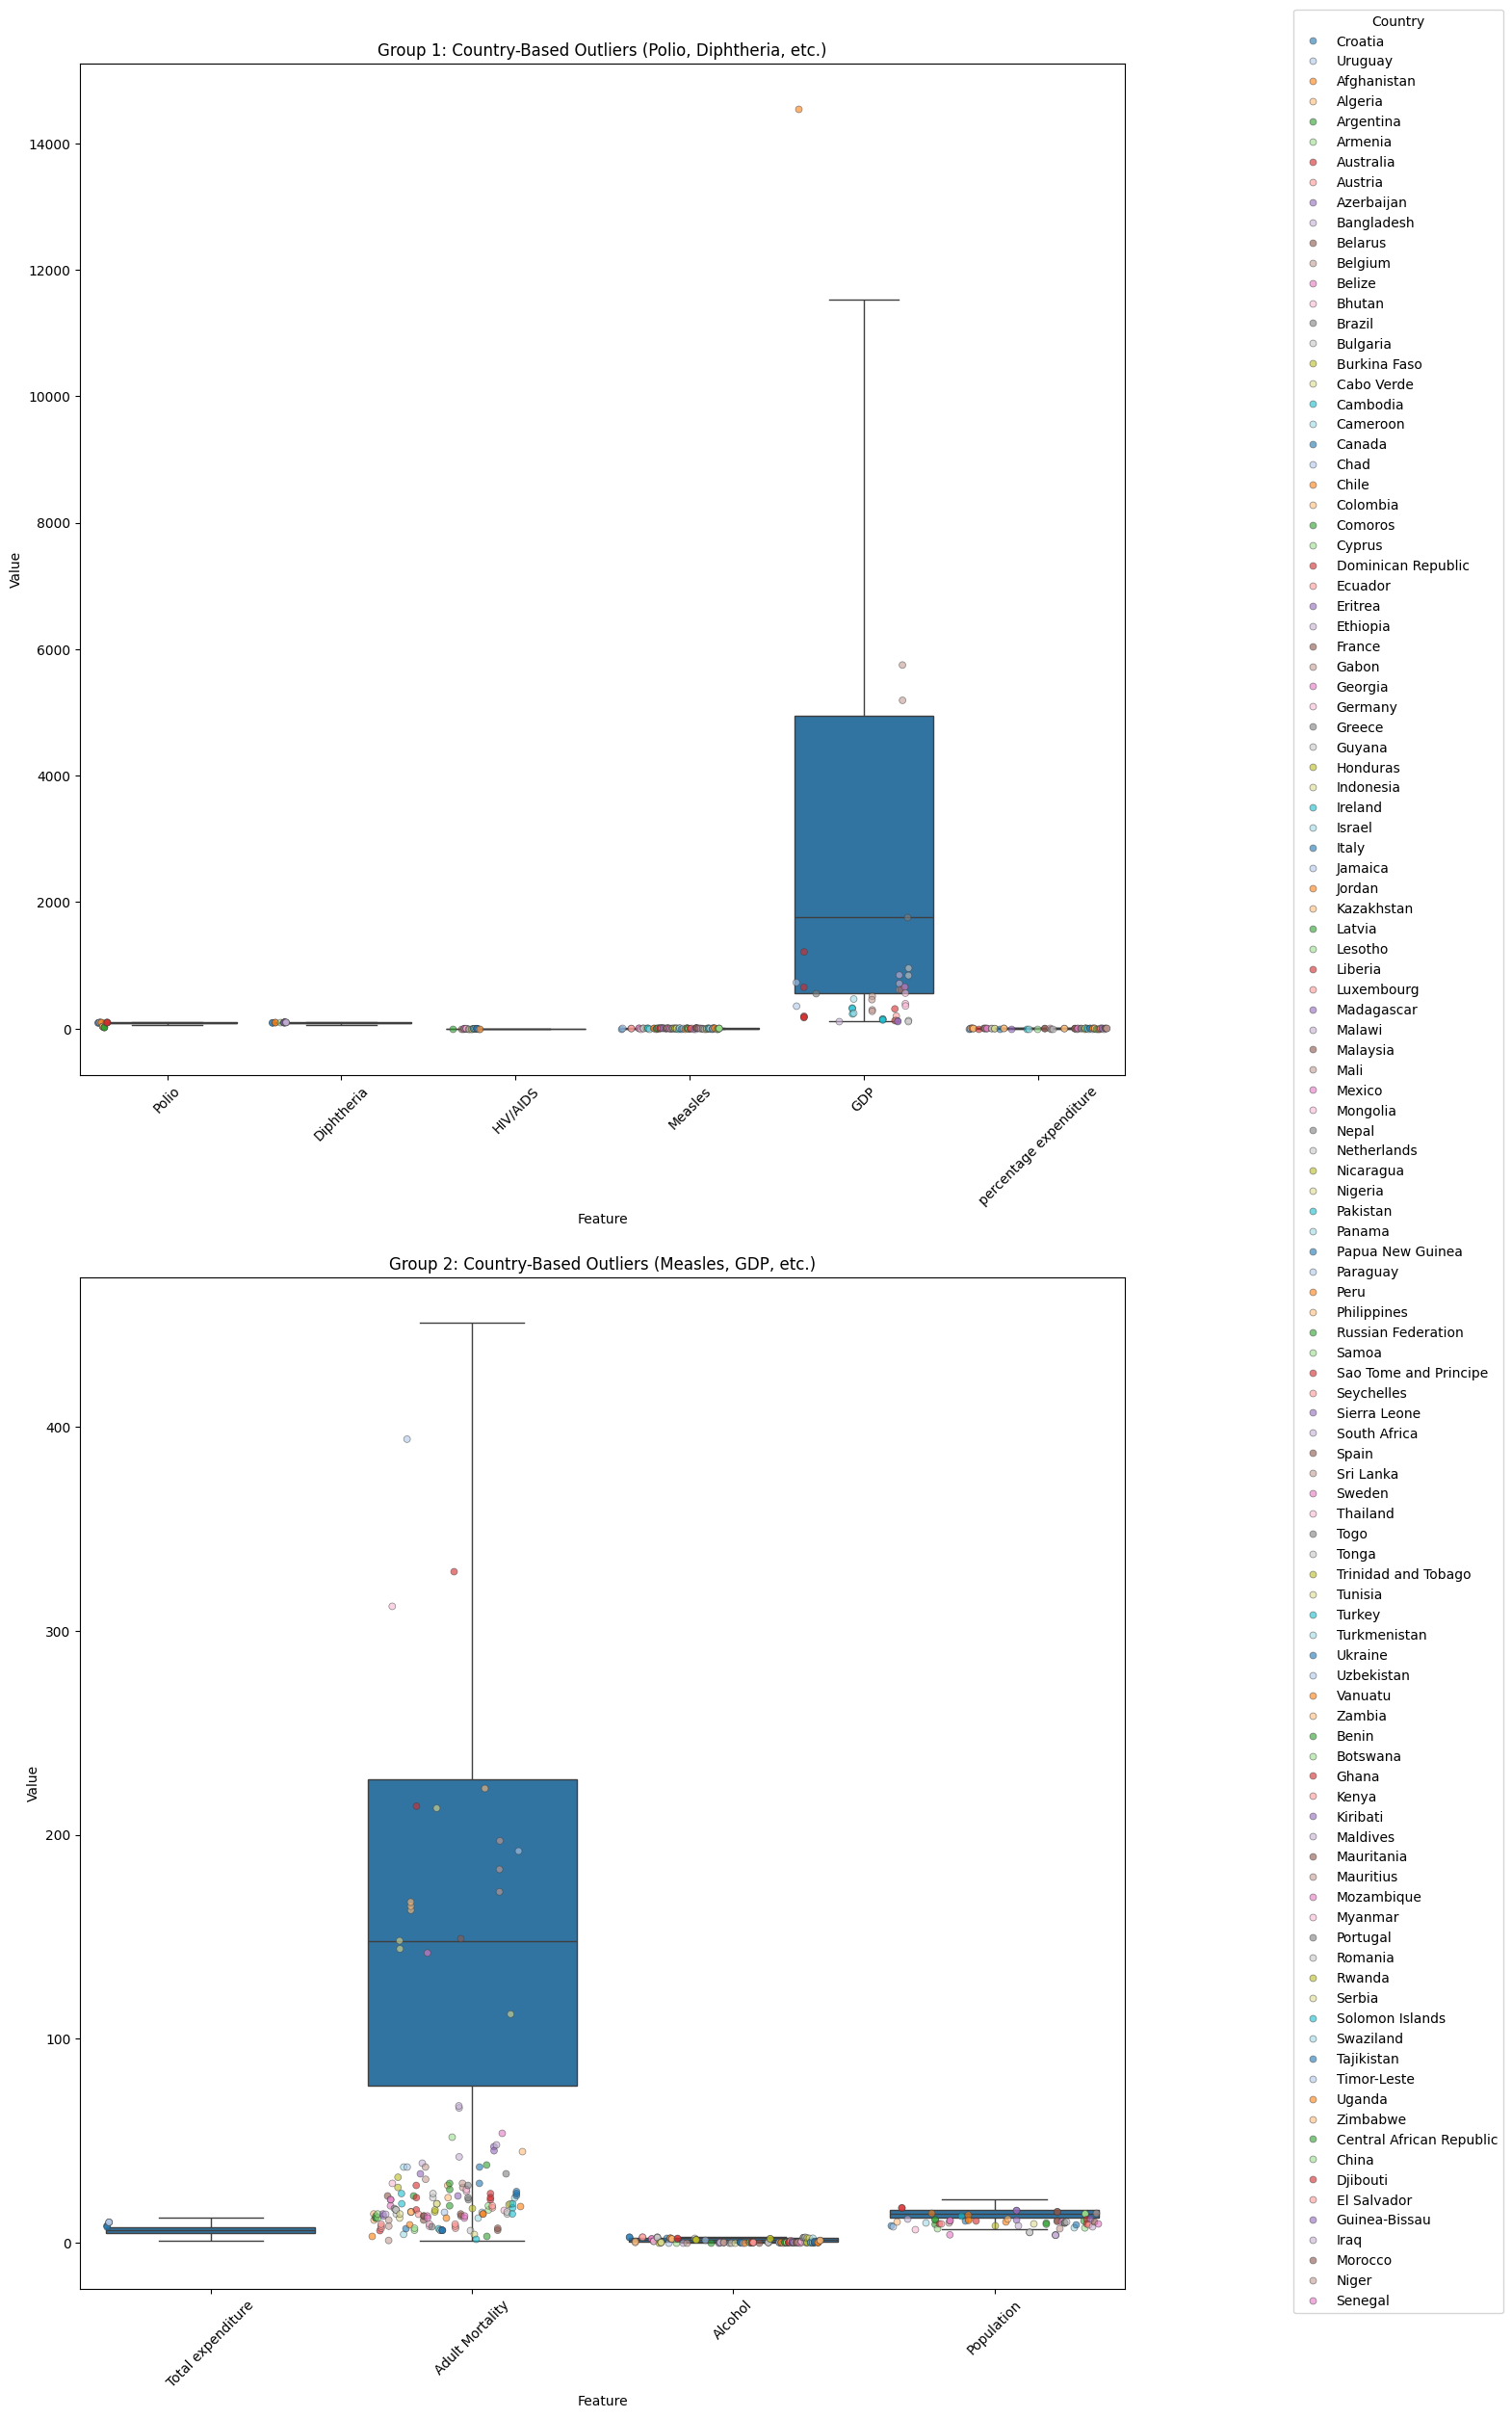

In [25]:

# === First feature group ===
features_1 = ['Polio', 'Diphtheria', 'HIV/AIDS', 'Measles', 'GDP', 'percentage expenditure']

# === Second feature group ===
features_2 = ['Total expenditure', 'Adult Mortality', 'Alcohol', 'Population']

# === Prepare melted data for both groups ===
def melt_and_tag_outliers(df, features):
    melted = df[['Country'] + features].melt(id_vars='Country', var_name='Feature', value_name='Value')

    def detect_and_tag_outliers(group):
        q1 = group['Value'].quantile(0.25)
        q3 = group['Value'].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        group['Outlier'] = (group['Value'] < lower) | (group['Value'] > upper)
        return group

    tagged = melted.groupby(['Country', 'Feature'], group_keys=False).apply(detect_and_tag_outliers)
    return tagged

df_tagged_1 = melt_and_tag_outliers(df, features_1)
df_tagged_2 = melt_and_tag_outliers(df, features_2)

# === Create subplots ===
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(14, 30))  # reduce figure height


# --- Plot 1 ---
sns.boxplot(data=df_tagged_1, x='Feature', y='Value', showfliers=False, ax=ax1)
sns.stripplot(
    data=df_tagged_1[df_tagged_1['Outlier']],
    x='Feature',
    y='Value',
    hue='Country',
    dodge=True,
    jitter=True,
    marker='o',
    alpha=0.6,
    linewidth=0.5,
    edgecolor='gray',
    palette='tab20',
    ax=ax1
)
ax1.set_title("Group 1: Country-Based Outliers (Polio, Diphtheria, etc.)")
ax1.tick_params(axis='x', rotation=45)
ax1.legend_.remove()


# --- Plot 2 ---
sns.boxplot(data=df_tagged_2, x='Feature', y='Value', showfliers=False, ax=ax2)
sns.stripplot(
    data=df_tagged_2[df_tagged_2['Outlier']],
    x='Feature',
    y='Value',
    hue='Country',
    dodge=True,
    jitter=True,
    marker='o',
    alpha=0.6,
    linewidth=0.5,
    edgecolor='gray',
    palette='tab20',
    ax=ax2
)
ax2.set_title("Group 2: Country-Based Outliers (Measles, GDP, etc.)")
ax2.tick_params(axis='x', rotation=45)

ax2.legend_.remove()

# === Add legend outside the full figure ===
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, title='Country', bbox_to_anchor=(1.02, 0.5), loc='center left')
plt.show()


### Task 4: Identify Potential Features

In [26]:
# Variance Inflation Factor to measure multicollinearity
# High VIF (> 10): The feature is highly redundant — it’s linearly predictable from other features.
#Low VIF (< 5): Low multicollinearity — the feature gives unique information.


X = df_final.select_dtypes(include=[float, int]).drop(columns=['Life expectancy'])
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data.sort_values('VIF', ascending=False))

                            Feature         VIF
8                 under-five deaths  204.969149
2                     infant deaths  203.654336
0                              Year  112.059810
11                       Diphtheria   98.715916
18                        Schooling   70.916348
9                             Polio   65.433960
17  Income composition of resources   38.512415
5                       Hepatitis B   32.875948
14                       Population   30.743100
4            percentage expenditure   17.126513
15              thinness 1-19 years   16.181613
16               thinness 5-9 years   15.978122
10                Total expenditure    9.090253
7                               BMI    8.472045
3                           Alcohol    6.524215
1                   Adult Mortality    5.092476
6                           Measles    2.848901
13                              GDP    2.286574
12                         HIV/AIDS    1.675964


In [27]:
selected_features = [
    'Adult Mortality',
    'Alcohol',
    'Total expenditure',
    'Measles',
    'HIV/AIDS',
    'GDP',
    'BMI'
]

###  Task 5: Feature Engineering

In [28]:
df_final['Immunization Score'] = df_final[['Polio', 'Diphtheria', 'Hepatitis B']].mean(axis=1)
df_final['HIV Impact Score'] = df_final['HIV/AIDS'] * df_final['Adult Mortality']
df_final['Health Investment'] = df_final['percentage expenditure'] * df_final['GDP']
df_final['Healthcare Access Ratio'] = df_final['Total expenditure'] / (df_final['GDP'] + 1e-5)
df_final['Mortality Rate Ratio'] = df_final['Adult Mortality'] / (df_final['Life expectancy'] + 1e-5)
df_final['Schooling vs Alcohol'] = df_final['Schooling'] / (df_final['Alcohol'] + 1e-5)
df_final['Resource Efficiency'] = df_final['Income composition of resources'] * df_final['Schooling']
df_final['Health Spending Per Capita'] = df_final['Total expenditure'] / (df_final['Population'] + 1e-5)
df_final['Population GDP Ratio'] = df_final['Population'] / (df_final['GDP'] + 1e-5)
df_final['BMI Deviation'] = abs(df_final['BMI'] - 22.5)
df_final['Thinness Ratio'] = df_final['thinness 1-19 years'] / (df_final['thinness 5-9 years'] + 1e-5)
df_final['Healthcare Access Score'] = df_final['Immunization Score'] * df_final['Health Investment']
df_final['GDP per Health $'] = df_final['GDP'] / (df_final['Total expenditure'] + 1e-5)
df_final['Child Vulnerability Index'] = 0.6 * df_final['HIV/AIDS'] + 0.4 * (df_final['under-five deaths'] + df_final['infant deaths'])

### Task 6: Impact of New Features

In [29]:
# Features before engineering
X_base = df_final[selected_features]
y = df_final['Life expectancy']

# Cross-validation with original features
base_model = LinearRegression()
base_score = cross_val_score(base_model, X_base, y, cv=5, scoring='r2').mean()

# Features after adding engineered ones
engineered_features = ['Immunization Score', 'Health Investment', 'Healthcare Access Ratio', 
                       'Mortality Rate Ratio', 'Schooling vs Alcohol', 
                       'Resource Efficiency', 'Health Spending Per Capita', 'Population GDP Ratio', 'BMI Deviation', 'Thinness Ratio',
                       'Healthcare Access Score', 'GDP per Health $', 'HIV Impact Score']
X_eng = df_final[selected_features + engineered_features]

# Cross-validation with engineered features
eng_model = LinearRegression()
eng_score = cross_val_score(eng_model, X_eng, y, cv=5, scoring='r2').mean()

print(f"R² (Base Features Only): {base_score:.4f}")
print(f"R² (With Engineered Features): {eng_score:.4f}")


R² (Base Features Only): 0.6987
R² (With Engineered Features): 0.8470


### Task 7: Select Key Variables for Visualization

In [30]:
df[['Life expectancy', 'percentage expenditure', 'Schooling', 'Adult Mortality', 'Income composition of resources', 'HIV/AIDS']].corr()

,Life expectancy,percentage expenditure,Schooling,Adult Mortality,Income composition of resources,HIV/AIDS
Life expectancy,1.000000,0.550091,0.727630,-0.702523,0.721083,-0.592236
percentage expenditure,0.550091,1.000000,0.600611,-0.303753,0.553091,-0.164061
Schooling,0.727630,0.600611,1.000000,-0.421171,0.784741,-0.211840
Adult Mortality,-0.702523,-0.303753,-0.421171,1.000000,-0.442203,0.550691
Income composition of resources,0.721083,0.553091,0.784741,-0.442203,1.000000,-0.248590
HIV/AIDS,-0.592236,-0.164061,-0.211840,0.550691,-0.248590,1.000000


### Task 8: Visualizations

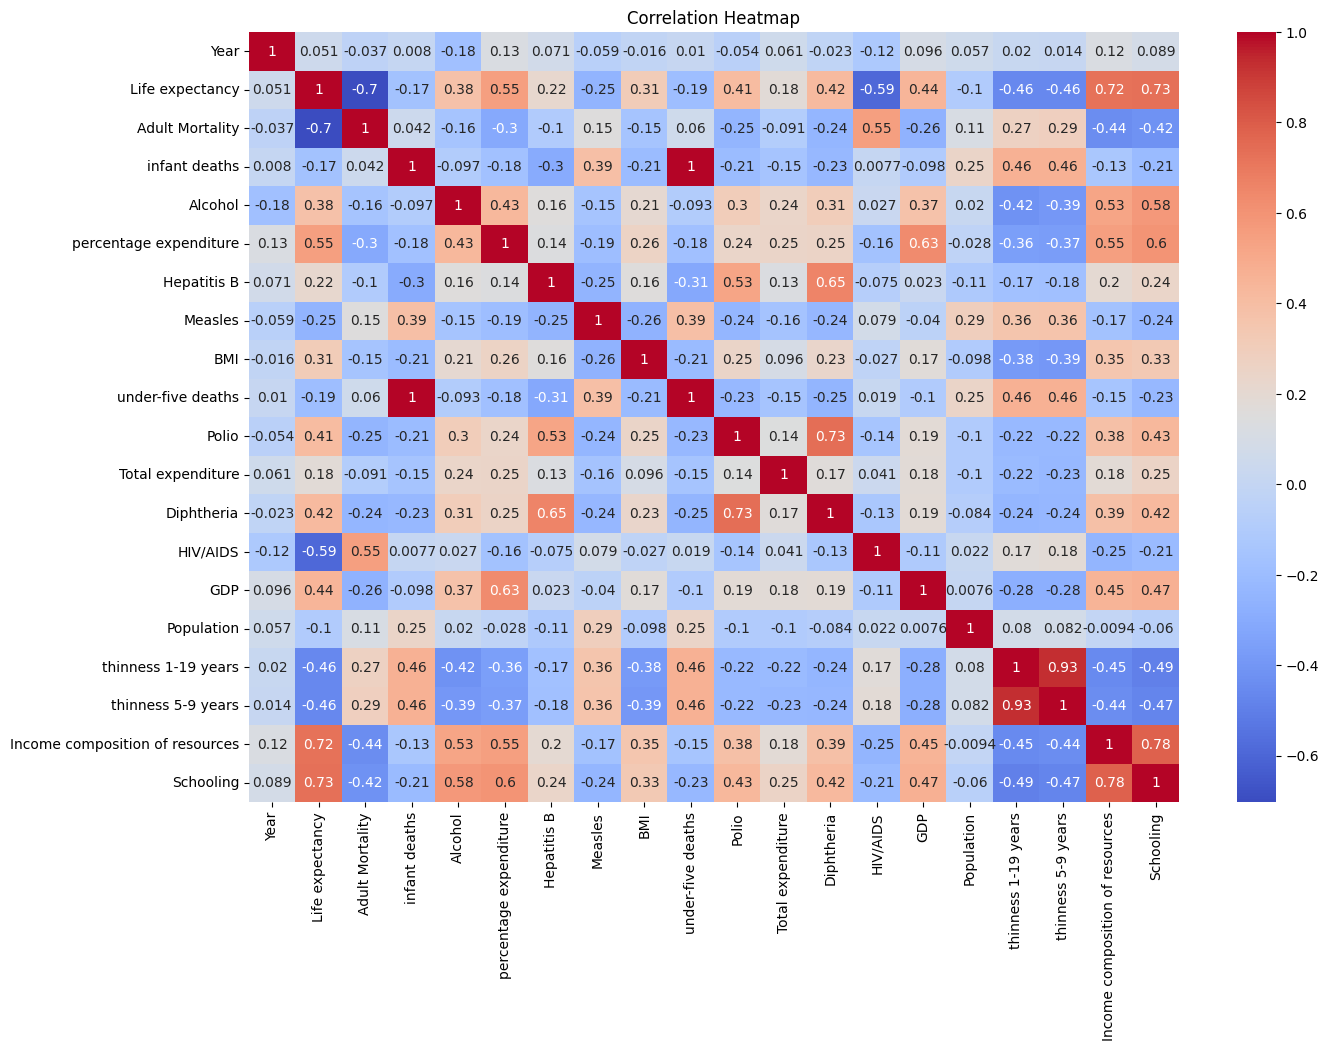

In [31]:
plt.figure(figsize=(15,10))
sns.heatmap(df.select_dtypes(include='number').corr(), cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap')
plt.show()

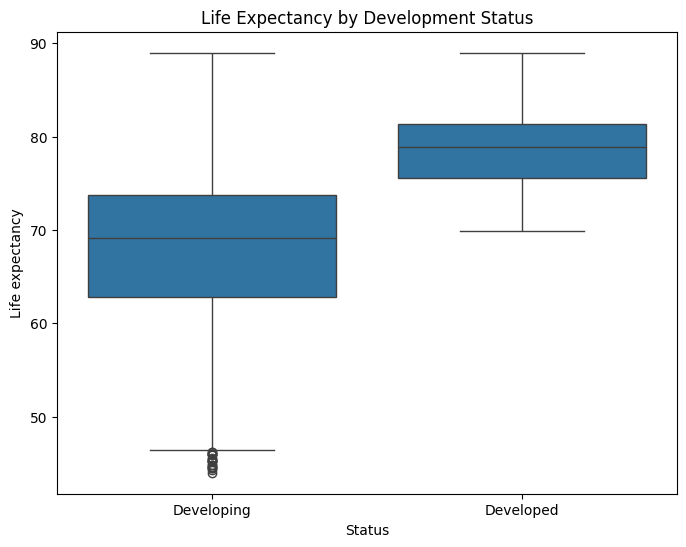

In [32]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Status', y='Life expectancy', data=df)
plt.title('Life Expectancy by Development Status')
plt.show()

<Axes: title={'center': 'Top 10 Countries by Avg Life Expectancy'}, xlabel='Country'>

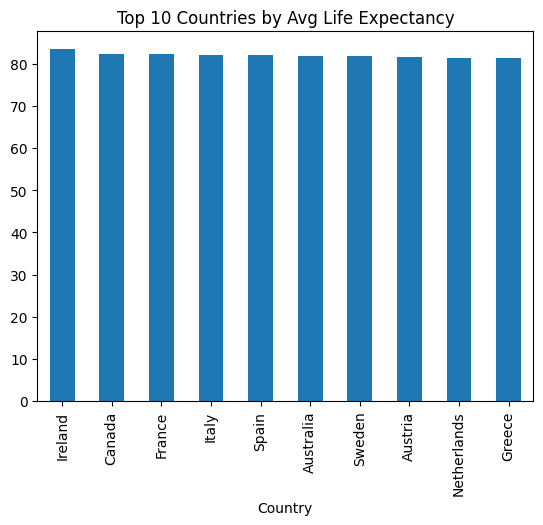

In [33]:
avg_life = df_final.groupby('Country')['Life expectancy'].mean().sort_values(ascending=False).head(10)
avg_life.plot(kind='bar', title='Top 10 Countries by Avg Life Expectancy')



<Axes: title={'center': 'Worst 10 Countries by Avg Life Expectancy'}, xlabel='Country'>

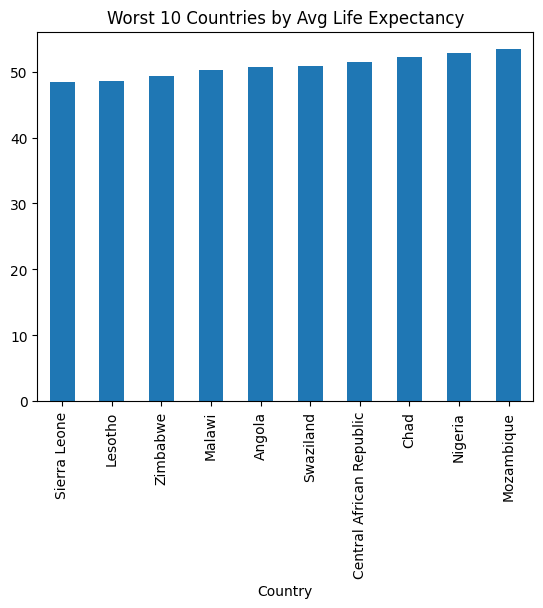

In [44]:
avg_life = df_final.groupby('Country')['Life expectancy'].mean().sort_values(ascending=True).head(10)
avg_life.plot(kind='bar', title='Worst 10 Countries by Avg Life Expectancy')



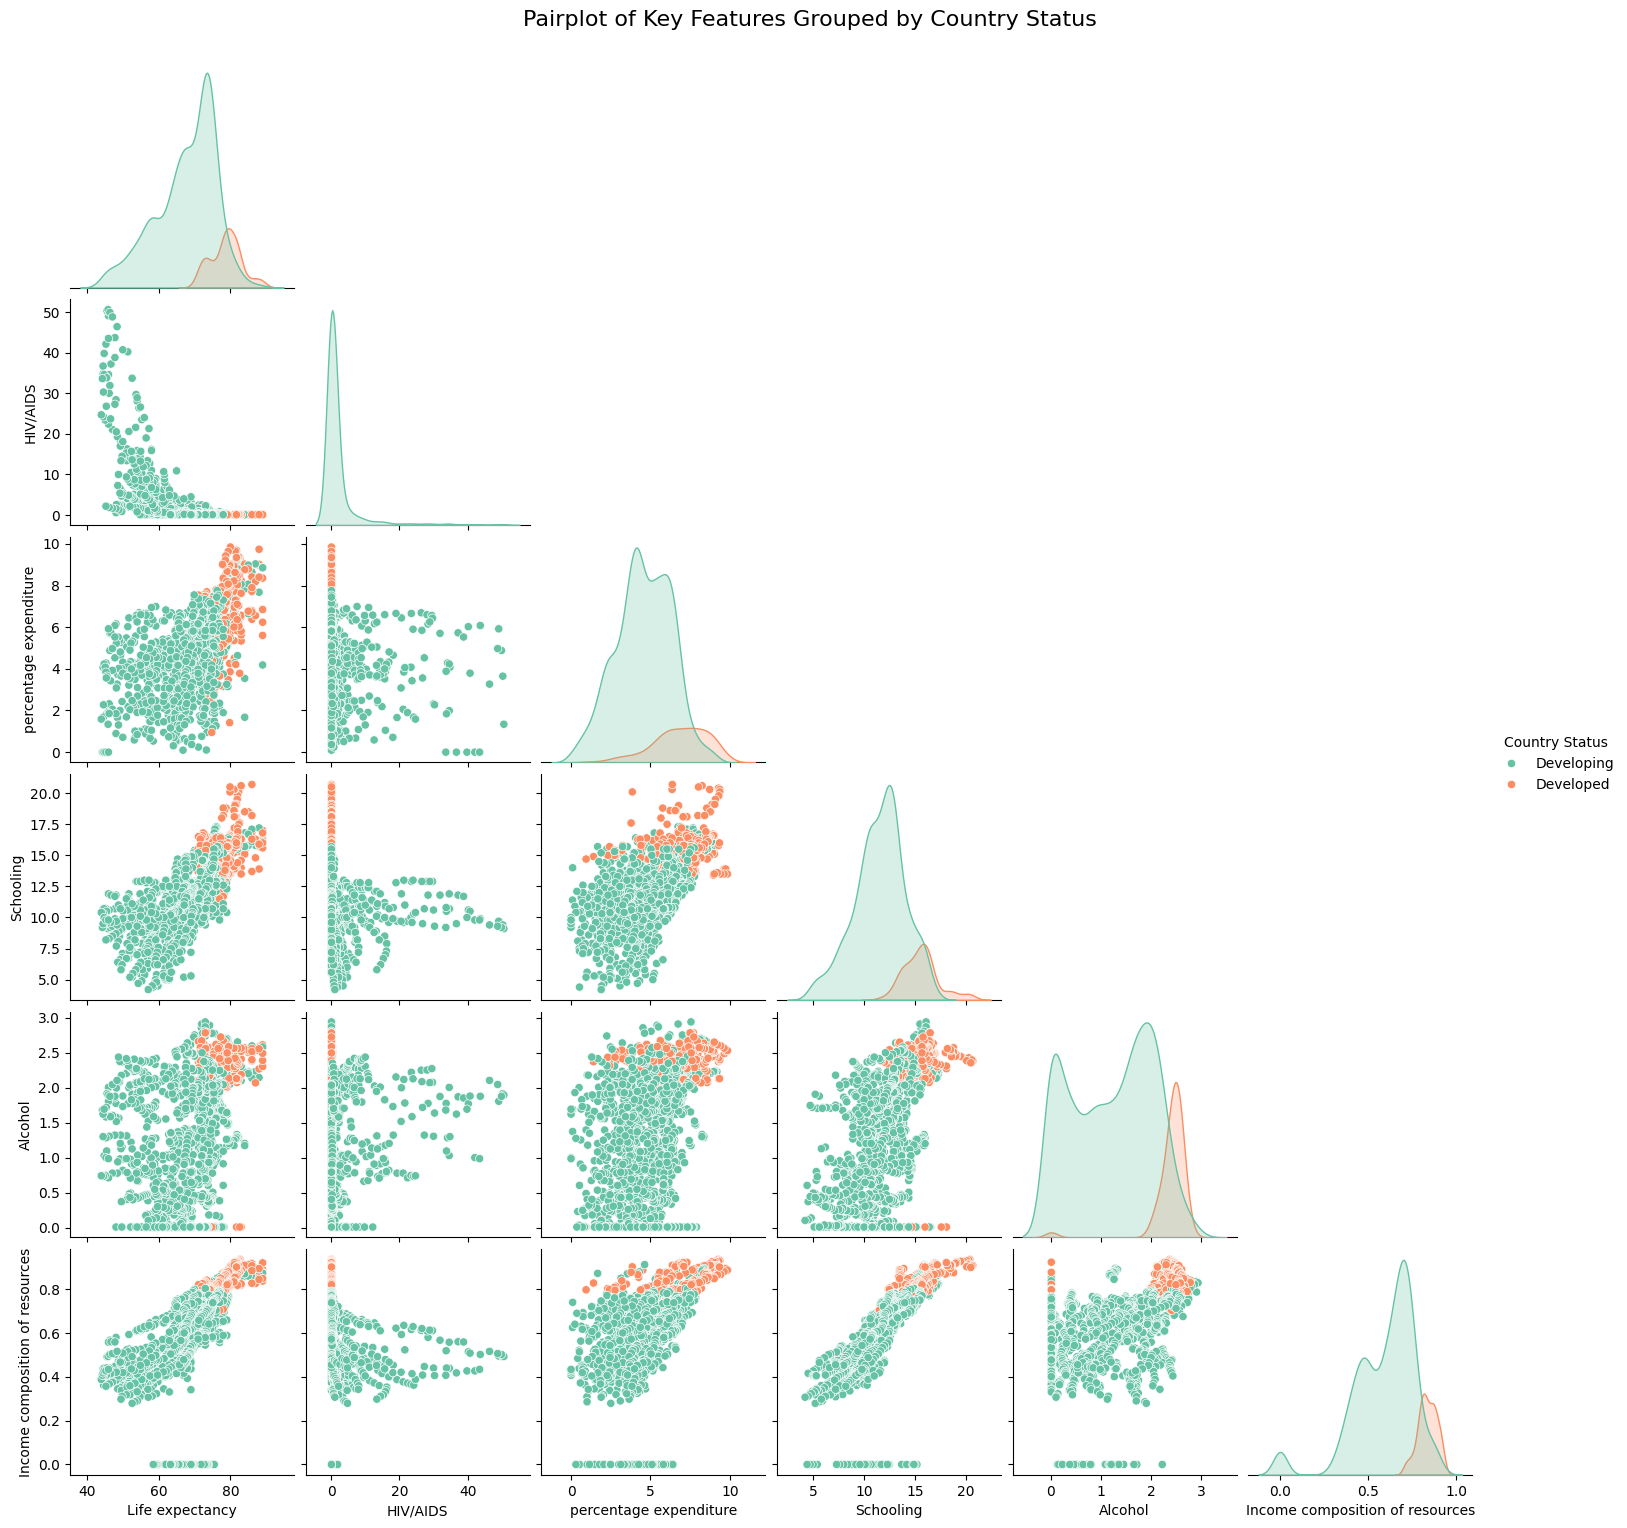

In [34]:
# Create the pairplot with hue (e.g., by 'Status' column: 'Developed' or 'Developing')
plot = sns.pairplot(
    df_final[['Life expectancy', 'HIV/AIDS', 'percentage expenditure', 
              'Schooling', 'Alcohol', 'Income composition of resources', 'Status']],
    hue='Status',                    # Add color grouping by 'Status'
    diag_kind='kde',                # KDE for diagonal plots
    palette='Set2',                 # Choose a readable color palette
    corner=True                     # Optional: show only lower triangle to avoid repetition
)

# Add a title to the figure
plot.fig.suptitle("Pairplot of Key Features Grouped by Country Status", y=1.02, fontsize=16)

# Show the legend (usually shown by default with hue, but you can reposition or customize it)
plot._legend.set_title("Country Status")  # Custom legend title

plt.show()



Text(0.5, 1.0, 'Immunization Score by Country Type')

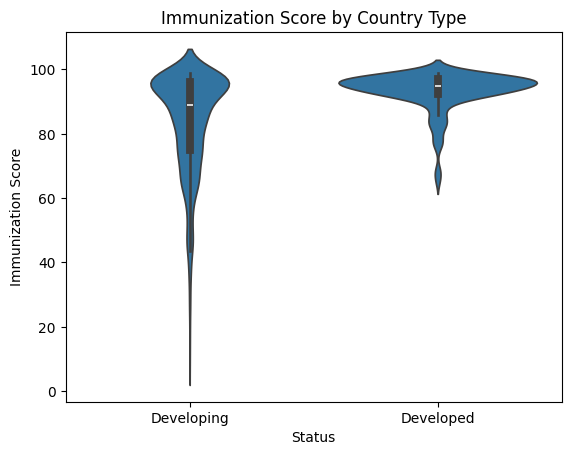

In [35]:
sns.violinplot(x='Status', y='Immunization Score', data=df_final)
plt.title("Immunization Score by Country Type")


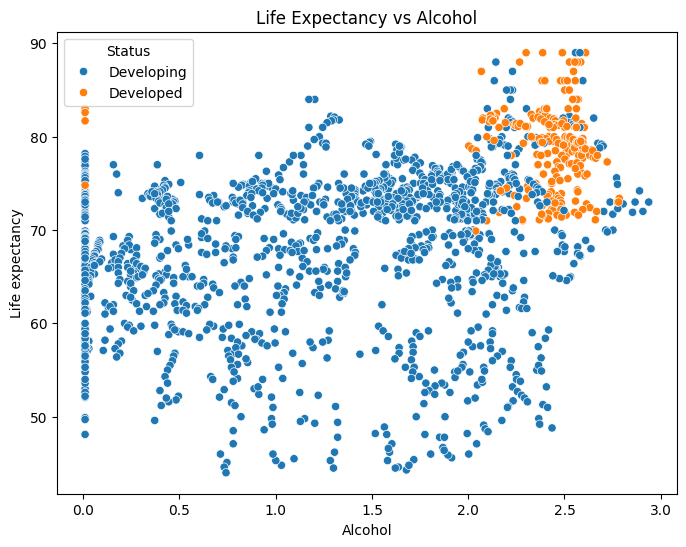

In [36]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Alcohol', y='Life expectancy', hue='Status')
plt.title('Life Expectancy vs Alcohol')
plt.show()

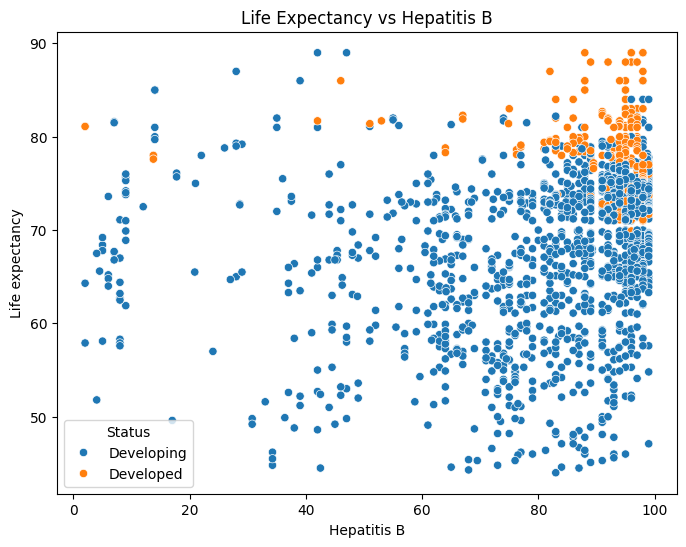

In [37]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Hepatitis B', y='Life expectancy', hue='Status')
plt.title('Life Expectancy vs Hepatitis B')
plt.show()

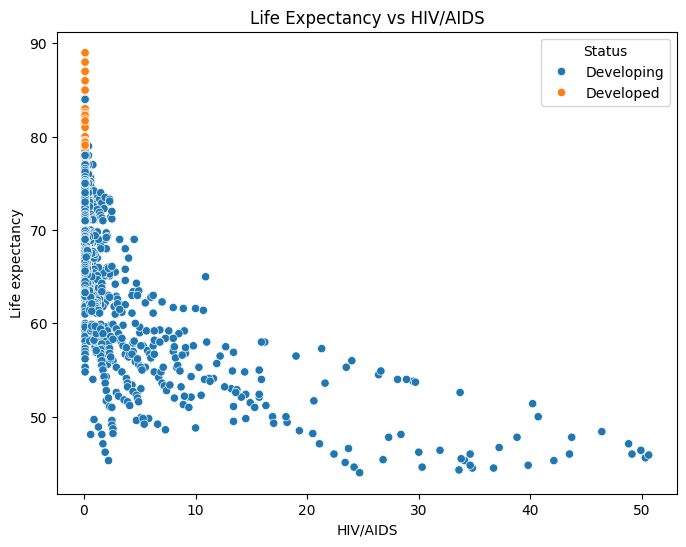

In [38]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='HIV/AIDS', y='Life expectancy', hue='Status')
plt.title('Life Expectancy vs HIV/AIDS')
plt.show()

In [39]:
# 3D Plot
fig = px.scatter_3d(df, x='HIV/AIDS', y='Adult Mortality', z='Life expectancy',
    color='Status', size='Population')
fig.show()

In [40]:
fig = px.scatter_3d(df_final,
    x='GDP',
    y='Health Investment',
    z='Life expectancy',
    color='Status',
    hover_name='Country',
    size='Population',
    title="3D Plot: GDP vs Health Investment vs Life Expectancy")

fig.show()


### Task 9: Interpretation
- Higher GDP and schooling are associated with higher life expectancy.
- Developing countries tend to have more outliers and lower average life expectancy.
- HIV/AIDS has a strong negative correlation with life expectancy.

### Task 10: Data Splitting and Model Training

In [41]:
X = df_final[selected_features + engineered_features]
 
y = df_final['Life expectancy']

# Split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

print(f"{'Model':<25}{'Train R²':>12}{'Test R²':>12}")
print("=" * 50)

for name, model in models.items():
    model.fit(X_train, y_train)
    r2_train = r2_score(y_train, model.predict(X_train))
    r2_test = r2_score(y_test, model.predict(X_test))
    print(f"{name:<25}{r2_train:>12.4f}{r2_test:>12.4f}")

Model                        Train R²     Test R²
Linear Regression              0.8887      0.8940
Decision Tree                  1.0000      0.9025
Random Forest                  0.9948      0.9576
Gradient Boosting              0.9749      0.9440
K-Nearest Neighbors            0.5652      0.3497
XGBoost                        0.9999      0.9559


### Task 11: Cross Validation and Model Evaluation

In [43]:
print(f"{'Model':<25}{'CV R² (Mean)':>15}{'Std Dev':>12}{'MAE (Mean)':>15}")
print("=" * 70)

for name, model in models.items():
    # R² scores
    r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    
    # MAE scores (note: cross_val_score returns negative MAE)
    mae_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
    mae_scores = -mae_scores  # Convert to positive

    print(f"{name:<25}{np.mean(r2_scores):>15.4f}{np.std(r2_scores):>12.4f}{np.mean(mae_scores):>15.4f}")


Model                       CV R² (Mean)     Std Dev     MAE (Mean)
Linear Regression                 0.8470      0.0571         2.3210
Decision Tree                     0.8453      0.0499         2.3785
Random Forest                     0.9187      0.0179         1.7443
Gradient Boosting                 0.9240      0.0096         1.7656
K-Nearest Neighbors               0.3167      0.0933         5.3738
XGBoost                           0.9152      0.0187         1.8067


### Task 12: Conclusion and Recommendations
- **Key Findings**: Life expectancy is positively influenced by GDP, schooling, and healthcare access. HIV/AIDS is a major negative predictor.
- **Model Performance**: The linear model gives reasonable accuracy with cross-validation.
- **Recommendation**: Focus on improving education, economic stability, and healthcare to raise life expectancy.